In [70]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from operator import itemgetter
from ipynb.fs.full.TP_adv_rob_tools import test_dataset, test_loader, compute_accuracy, get_deep_model 

In [3]:
epochs = 11
model = get_deep_model(epochs)

Retraining /Users/m.goibert/Documents/Criteo/TP_adv_Robustness/trained_models/MNIST_LeNet_11_epochs.model
Starting epoch 0 (4.0531158447265625e-06 secs) and lr = [0.001]
Validation loss = 0.4191
Starting epoch 1 (26.754412174224854 secs) and lr = [0.001]
Validation loss = 0.2867
Starting epoch 2 (28.888372898101807 secs) and lr = [0.001]
Validation loss = 0.244
Starting epoch 3 (27.19203495979309 secs) and lr = [0.001]
Validation loss = 0.2188
Starting epoch 4 (27.585323095321655 secs) and lr = [0.001]
Validation loss = 0.2006
Starting epoch 5 (27.03295588493347 secs) and lr = [0.001]
Validation loss = 0.1698
Starting epoch 6 (28.10900092124939 secs) and lr = [0.001]
Validation loss = 0.1862
Starting epoch 7 (26.806719064712524 secs) and lr = [0.001]
Validation loss = 0.1571
Starting epoch 8 (27.441033124923706 secs) and lr = [0.001]
Validation loss = 0.1402
Starting epoch 9 (26.49860405921936 secs) and lr = [0.001]
Validation loss = 0.1572
Validation accuracy = 0.987
Starting epoch 10

In [21]:
x_examples, y_examples = list(map(itemgetter(0), test_dataset)), list(map(itemgetter(1), test_dataset))
x_examples = torch.stack(x_examples).view(-1,28,28).numpy()

# First, looking at the data

Before starting with whatever we want to do, it is important to always have a look to the data, to understand what we are looking at, what kind of shape it has, etc.

Here, we start with a very simple code snippet thait aims at visualizing the data.

[WHAT YOU HAVE TO DO] Based on this simple code snippet, complete the function "show_dataset_and_predictions" to display the image, the true label of the image and the prediction made by the model.

You may need to use:
- torch.from_numpy(x) --> it convert a numpy array a to a pytorch tensor
- x.view(dim0, dim1, dim2, ...) --> it quickly reshape a pytorch tensor according to the dimension given
- x.double() --> it converts x to a "double" type of data
- x.detach()
- x.numpy() --> it converts a pytorch tensor to a numpy array

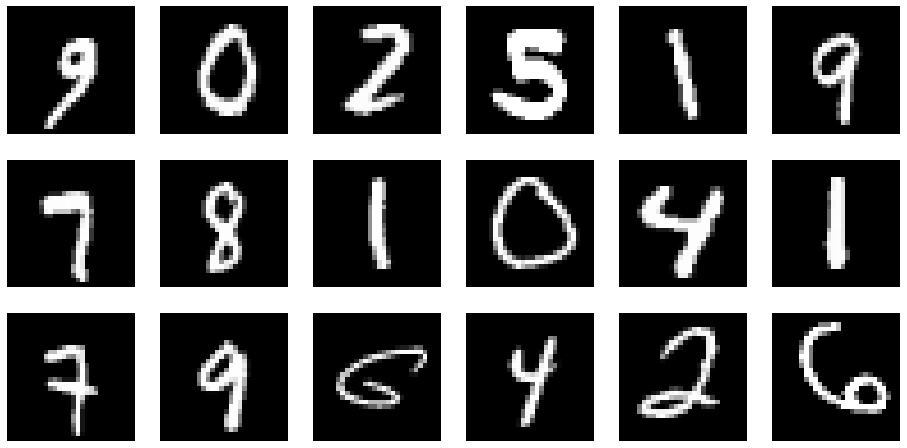

In [22]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_examples[i], cmap="gray")
    plt.axis("off")
plt.show()

In [38]:
def show_dataset_and_predictions(x, y, model):
    plt.figure(figsize=(16, 8))
    for i in range(0, 18):
        plt.subplot(3, 6, i + 1)
        plt.imshow(x[i], cmap="gray")
            
        # Here
        plt.text(0, 2, s=f"y_true={y[i]}",
              bbox=dict(facecolor='blue', alpha=0.9),
              color="white")
        prediction = model(torch.from_numpy(x[i]).view(-1,1,28,28).double()).detach().numpy()
        prediction = np.argmax(prediction)

        color = "green" if prediction == y[i] else "red"
        plt.text(0, 26, s=f"y_pred={prediction}",
              bbox=dict(facecolor=color, alpha=0.9),
              color="white")

        plt.axis("off")
    plt.show()    

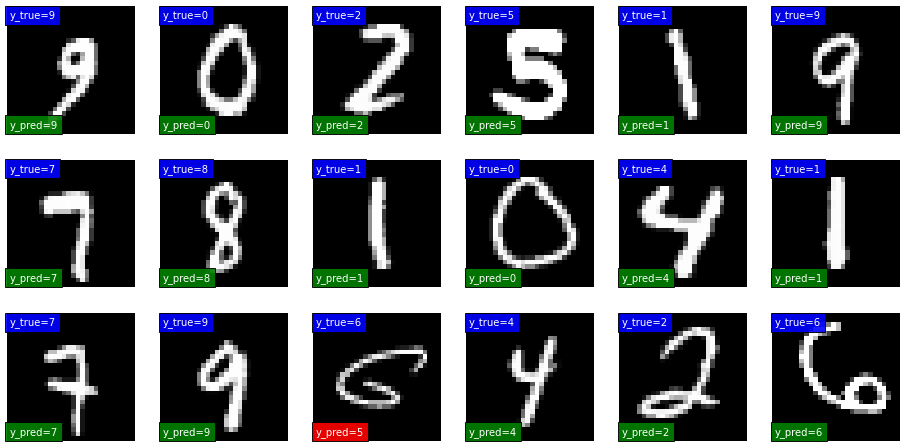

In [39]:
# Check if what you did works
show_dataset_and_predictions(x_examples, y_examples, model)

# An easy adversarial attack

Now we know a bit more how our data looks like, let us dive a bit more into adversarial robustness. First things first, if we want to study the robustness of our model, we need an attack...

## FGSM

FGSM is a widely used attack and still a state-of-the-art one because 1) It is very easy to understand and to implement, 2) It is really quick to run and 3) It works kind of well.

As a reminder, FGSM works as follows:
- It has a parameter "epsilon" which controls the strengh of the attack
- FGSM is going to add epsilon to the input in the same direction of the gradient of the loss function of our model in that input (the idea is that we want to make the loss function higher, so we go in the same direction)

[WHAT YOU HAVE TO DO] Complete the function "fgsm_attack" to implement the attack.

In [80]:
def fgsm_attack(model, x, y, epsilon):
    if type(x) is np.ndarray:
        x = torch.from_numpy(x).view(-1,1,28,28).double()
    else:
        x = x.view(-1,1,28,28).double()
    if isinstance(y, int):
        y = torch.from_numpy(np.array([y]))
    elif type(y) is np.ndarray:
        y = torch.from_numpy(y)
    loss_func = nn.CrossEntropyLoss()
    x.requires_grad = True
            
    y_pred = model(x)
    model.zero_grad()
    loss = loss_func(y_pred, y)
    loss.backward()
    
    x_adv = x + epsilon*x.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    
    return x_adv

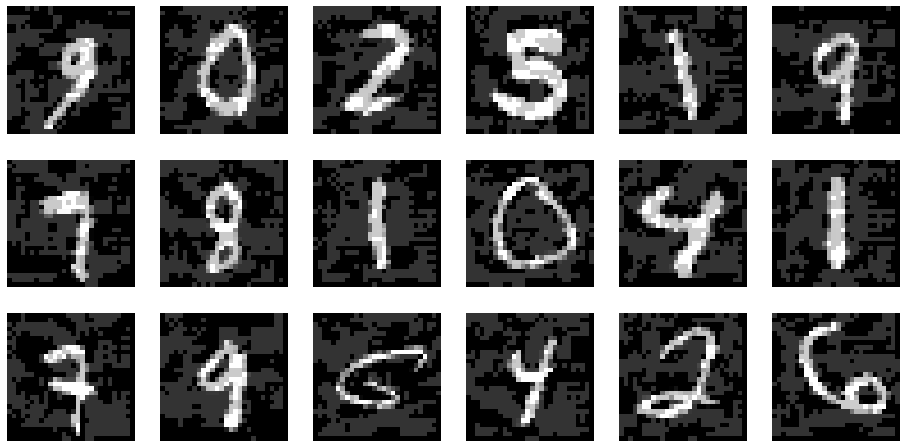

In [65]:
epsilon = 0.2
x_advs = []
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    x_advs.append(fgsm_attack(model, x_examples[i], y_examples[i], epsilon).view(28,28).detach().numpy())
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_advs[i], cmap="gray")
    plt.axis("off")
plt.show()

Now that we have implemented FGSM, let's check is relevance on some examples.

[WHAT YOU NEED TO DO] Run the FGSM on as many examples from x_examples as needed to call the function "show_dataset_and_predictions" so that we have:
- adversarial images displayed (not "clean" ones)
- the true label (of the "clean" image)
- the prediction of the adversarial image

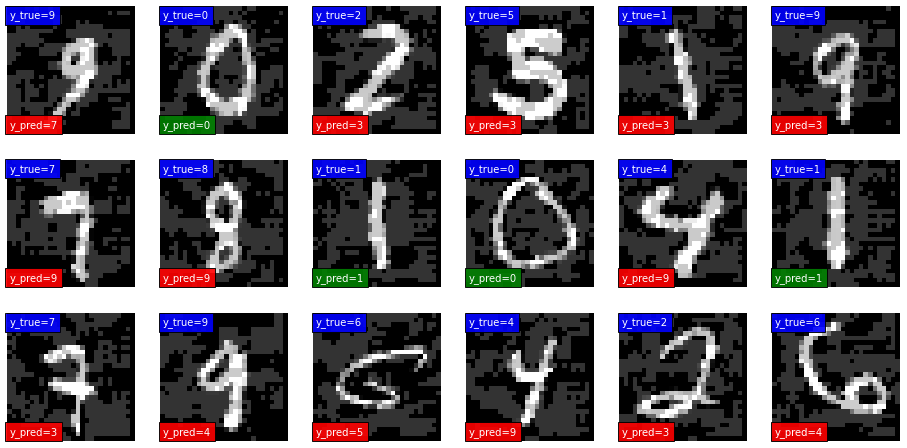

In [69]:
epsilon = 0.2
y_advs = []
x_advs = []
for i in range(0, 18):
    x_adv = fgsm_attack(model, x_examples[i], y_examples[i], epsilon)
    x_advs.append(x_adv.view(28,28).detach().numpy())
    y_pred_adv = model(x_adv)
    y_advs.append(y_pred_adv.argmax(dim=1, keepdim=True))

show_dataset_and_predictions(x_advs, y_examples, model)

Now that we have a better idea of how good FGSM is, it is time to check that on more than a few visual examples. Here, we are going to run FGSM at a larger scale on our test datasets, and measure how accuracy changes with different epsilon paramaters.

[WHAT YOU NEED TO DO] Complete the following function to run FGSM on the complete test dataset and compute its accuracy. Then, plot the accuracy as a function of epsilon (the strengh parameter of the attack).

In [92]:
def run_attack(model, test_loader, epsilon):
    loss_func = nn.CrossEntropyLoss()
    correct = 0
    adv_examples = []

    total_clean_correct = 0
    total_adv_correct = 0
    for x, y in test_loader:
        #x.requires_grad = True
        x = x.double()
        y_pred = model(x)
        y_init_pred = y_pred.argmax(dim=1, keepdim=True)
        
        # How many good predictions model make on the current batch
        #init_correct = sum([1 for i in range(len(y)) if y[i] == y_init_pred[i]])

        x_adv = fgsm_attack(model, x, y, epsilon)
        y_pred_adv = model(x_adv)

        # Check for success
        y_final_pred_adv = y_pred_adv.argmax(dim=1, keepdim=True)
        adv_correct = sum([1 for i in range(len(y)) if (y[i] == y_final_pred_adv[i]) and (y[i] == y_init_pred[i])])
        
        #total_clean_correct += init_correct
        total_adv_correct += adv_correct

    print(f"Adv correct = {total_adv_correct}")
    return total_adv_correct/float(len(test_loader))

epsilon = 0.2
run_attack(model, test_loader, epsilon)

Adv correct = 8898
Adv correct = 8835
Adv correct = 8339
Adv correct = 6958
Adv correct = 4941
Adv correct = 2801
Adv correct = 586
Adv correct = 111
Adv correct = 50
Adv correct = 49
Adv correct = 114


[]

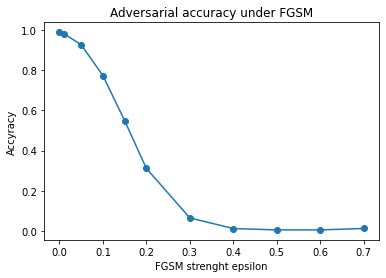

In [93]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
adv_accs = []
for epsilon in epsilons:
    adv_accs.append(run_attack(model, test_loader, epsilon))

plt.plot(epsilons, adv_accs, "o-")
plt.xlabel("FGSM strenght epsilon")
plt.ylabel("Accyracy")
plt.title("Adversarial accuracy under FGSM")
plt.plot()

# Visualizing adversarial perturbation

What does the adversarial perturbation look like? Can we see a pattern, can we deduce interesting stuff from there?

To try to answer this questions, we will first zoom on the adversarial perturbation.

[WHAT YOU NEED TO DO] Plot a clean image, its corresponding perturbation and the corresponding adversarial image side by side.

Is the attack successful? tensor([[True]])


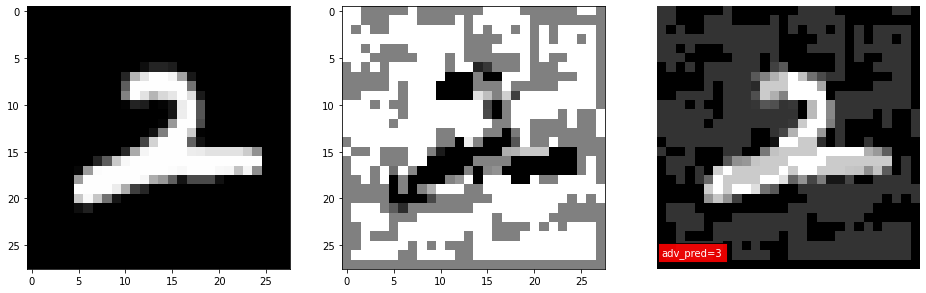

In [122]:
epsilon = 0.2
i = 31

x = x_examples[i]
x_adv = fgsm_attack(model, x, y_examples[i], epsilon)
print(f"Is the attack successful? {(model(x_adv).argmax(dim=1, keepdim=True) != y_examples[i])}")
perturbation = (torch.from_numpy(x) - x_adv).view(28,28).detach().numpy()

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(-1/epsilon * perturbation, cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(x_adv.view(28,28).detach().numpy(), cmap="gray")
plt.text(0, 26, s=f"adv_pred={int(model(x_adv).argmax(dim=1, keepdim=True))}",
              bbox=dict(facecolor="red", alpha=0.9),
              color="white")
plt.axis("off")
plt.show()

We realize that the attack is quite able to identify the true label, as shown by the black pixels in the perturbation... But it is difficult to see where the adversarial label comes from.

### Saliency map ?

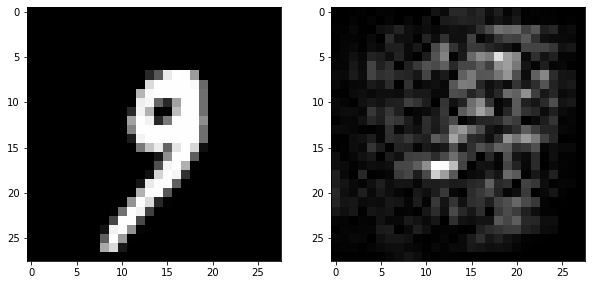

In [140]:
def saliency_map(x,y):

    x = torch.from_numpy(x).view(-1,1,28,28).double()
    x.requires_grad = True

    pred = model(x)
    score, ind = torch.max(pred, 1)
    score.backward()
    slc, _ = torch.max(torch.abs(x.grad), dim=0)
    slc = (slc - slc.min())/(slc.max()-slc.min())

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(x.detach().view(28,28).numpy(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(slc.view(28,28).numpy(), cmap="gray")
    plt.show()
    
    return slc

slc = saliency_map(x_examples[0],y_examples[0])

# Adversarial Training